In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# Any results you write to the current directory are saved as output.

In [2]:
df = pd.read_csv("/kaggle/input/drone-dataset-with-steering-angle-2/final_example.csv")
df.head()

,frame_id,steering_angle
0,1479425441182877835,-0.373665
1,1479425441232704425,-0.065396
2,1479425441282730750,-0.160735
3,1479425441332806714,0.317896
4,1479425441382790272,0.196493


In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
def show_img(path):
    img = mpimg.imread(path)
    print(img.shape)
    plt.figure()
    plt.imshow(img)
def print_random_img(n, path, lists = [], numbers = []):
    if len(lists) != 0:
        l = lists
    else:
        l = os.listdir(path)
    print(len(l))
    if len(numbers) != 0:
        for i in numbers:
            try:
                show_img(os.path.join(path, l[i]))
            except IndexError:
                print("Number in numbers is bigger than length of path list")
    else:
        for i in range(n):
            randomn = random.randint(0, len(l))
            show_img(os.path.join(path, l[randomn]))

5614
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)


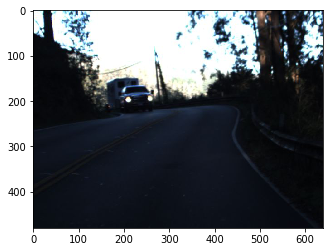

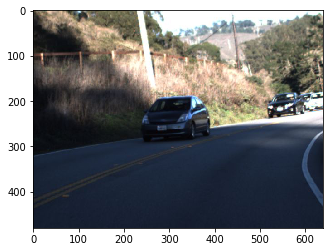

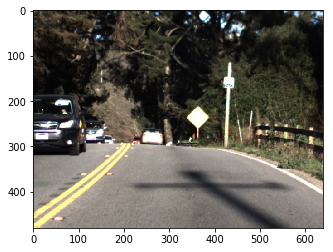

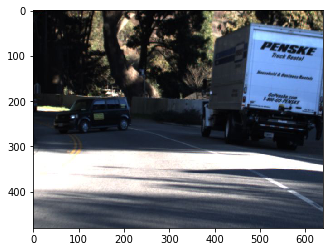

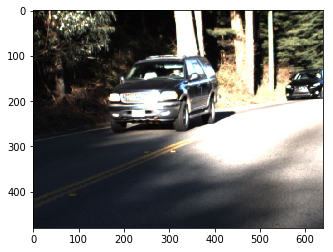

In [4]:
print_random_img(5, "/kaggle/input/drone-dataset-with-steering-angle-2/center")

In [5]:
x = list(df['frame_id'])
df_images = np.asarray(["/kaggle/input/drone-dataset-with-steering-angle-2/center/"+str(i)+".jpg" for i in x])

In [6]:
df = pd.DataFrame(list(zip(df_images, df["steering_angle"].apply(lambda x: 20*x))), 
               columns =['Image', 'Label'])

In [7]:
df.head()

,Image,Label
0,/kaggle/input/drone-dataset-with-steering-angl...,-7.473302
1,/kaggle/input/drone-dataset-with-steering-angl...,-1.307926
2,/kaggle/input/drone-dataset-with-steering-angl...,-3.214709
3,/kaggle/input/drone-dataset-with-steering-angl...,6.357921
4,/kaggle/input/drone-dataset-with-steering-angl...,3.929862


In [8]:
from sklearn.model_selection import train_test_split

df, df_test = train_test_split(df, test_size = 0.2)

In [9]:
df.head()

,Image,Label
1679,/kaggle/input/drone-dataset-with-steering-angl...,-5.322293
5376,/kaggle/input/drone-dataset-with-steering-angl...,-1.491874
1981,/kaggle/input/drone-dataset-with-steering-angl...,-3.633782
961,/kaggle/input/drone-dataset-with-steering-angl...,-5.080775
4066,/kaggle/input/drone-dataset-with-steering-angl...,-1.038708


In [10]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

data_generator_with_aug = ImageDataGenerator(
                                   validation_split = 0.2, rotation_range = 10,
                                   zoom_range = 0.1)

In [11]:
size = 256
class_mode = 'raw'
train_dg = data_generator_with_aug.flow_from_dataframe(dataframe= df, directory = None, class_mode = class_mode,
                                            x_col="Image", y_col="Label", target_size = (size,size),
                                           batch_size = 32, subset = 'training', shuffle = True)
val_dg = data_generator_with_aug.flow_from_dataframe(dataframe= df, directory = None, class_mode = class_mode,
                                            x_col="Image", y_col="Label", target_size = (size,size),
                                           batch_size = 32, subset = 'validation', shuffle = True)
test_dg = data_generator_with_aug.flow_from_dataframe(dataframe= df_test, directory = None, class_mode = class_mode,
                                            x_col="Image", y_col="Label", target_size = (size,size),
                                           batch_size = 32, shuffle = True)

Found 3593 validated image filenames.
Found 898 validated image filenames.
Found 1123 validated image filenames.


In [12]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Flatten, Dropout, Activation, MaxPooling2D
from keras.optimizers import SGD

def make_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(size, size, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1))
    return model

Using TensorFlow backend.


In [13]:
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.merge import add
from keras import regularizers
from keras.optimizers import Adam
from keras.losses import kullback_leibler_divergence as KLDivergence



def resnet8(img_width, img_height, img_channels, output_dim):
    """
    Define model architecture.
    
    # Arguments
       img_width: Target image widht.
       img_height: Target image height.
       img_channels: Target image channels.
       output_dim: Dimension of model output.
       
    # Returns
       model: A Model instance.
    """

    # Input
    img_input = Input(shape=(img_height, img_width, img_channels))

    x1 = Conv2D(32, (5, 5), strides=[2,2], padding='same')(img_input)
    x1 = MaxPooling2D(pool_size=(3, 3), strides=[2,2])(x1)

    # First residual block
    x2 = keras.layers.normalization.BatchNormalization()(x1)
    x2 = Activation('relu')(x2)
    x2 = Conv2D(32, (3, 3), strides=[2,2], padding='same',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x2)

    x2 = keras.layers.normalization.BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    x2 = Conv2D(32, (3, 3), padding='same',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x2)

    x1 = Conv2D(32, (1, 1), strides=[2,2], padding='same')(x1)
    x3 = add([x1, x2])

    # Second residual block
    x4 = keras.layers.normalization.BatchNormalization()(x3)
    x4 = Activation('relu')(x4)
    x4 = Conv2D(64, (3, 3), strides=[2,2], padding='same',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x4)

    x4 = keras.layers.normalization.BatchNormalization()(x4)
    x4 = Activation('relu')(x4)
    x4 = Conv2D(64, (3, 3), padding='same',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x4)

    x3 = Conv2D(64, (1, 1), strides=[2,2], padding='same')(x3)
    x5 = add([x3, x4])

    # Third residual block
    x6 = keras.layers.normalization.BatchNormalization()(x5)
    x6 = Activation('relu')(x6)
    x6 = Conv2D(128, (3, 3), strides=[2,2], padding='same',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x6)

    x6 = keras.layers.normalization.BatchNormalization()(x6)
    x6 = Activation('relu')(x6)
    x6 = Conv2D(128, (3, 3), padding='same',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x6)

    x5 = Conv2D(128, (1, 1), strides=[2,2], padding='same')(x5)
    x7 = add([x5, x6])

    x = Flatten()(x7)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    # Steering channel
    steer = Dense(output_dim)(x)

    model = Model(inputs=[img_input], outputs=[steer])
    print(model.summary())

    return model

my_model = resnet8(size, size, 3, 1)
my_model.compile(optimizer= 'rmsprop', loss= ["mse", KLDivergence], metrics=["mae", KLDivergence])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 2432        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 63, 63, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 63, 63, 32)   128         max_pooling2d_1[0][0]            
____________________________________________________________________________________________

ValueError: When passing a list as loss, it should have one entry per model outputs. The model has 1 outputs, but you passed loss=['mse', <function kullback_leibler_divergence at 0x7f07d3091f28>]

In [14]:
my_model.fit_generator(
        train_dg,
        steps_per_epoch=110,
        epochs=30,
        validation_data=val_dg, 
        validation_steps = 30)

RuntimeError: You must compile your model before using it.

In [15]:
from PIL import Image
def predict(df_test,number,model, divide = False):
    df = np.array_split(df_test, int(len(df_test)/ number))[0]
    array_pred = []
    array_real = []
    for i in range(len(df)):
        im = Image.open(df['Image'].iloc()[i])
        im = np.asarray(im.resize((size, size)))
        array_pred.append(model.predict(np.asarray([im])).tolist()[0][0])
        if divide:
            array_real.append(float(df['Label'].iloc()[i])/20)
        else:
            array_real.append(df['Label'].iloc()[i])
        
    return [array_pred, array_real]
        
        

In [16]:
u = predict(df_test, 10,my_model, divide = True)

In [17]:
u

[[-69.25917053222656,
  -101.7236099243164,
  -27.774677276611328,
  -48.403377532958984,
  -34.09025955200195,
  70.40914154052734,
  -90.61859893798828,
  64.2076644897461,
  -99.34136199951172,
  10.171600341796875,
  -21.73086166381836],
 [0.18822415154427302,
  0.285235328786075,
  -0.282796095870435,
  -0.0189689286053181,
  -0.321018800884485,
  -0.317234893701971,
  -0.38021831382065996,
  0.27603618428111104,
  -0.37434618789702706,
  0.0475918099284172,
  0.0106644524261356]]